In [ ]:

import os
import csv
import glob
from PIL import Image
from typing import Tuple, Any
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
import random


1 Необходимо загрузить исходный набор данных и соответствующие метки классов.

2 Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

3 Написать модель сверточной нейронной сети для решения задачи классификации.

4 Описать пайплайн предобработки данных (torchvision.transforms.Compose).

5 Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и batch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).

6 Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.

7 Оценить качество работы модели на тестовой выборке.

8 Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

9 Сохранить обученную модель.

10 Выполните повторную инициализацию модели и загрузку весов. Продемонстрируйте работоспособность модели (пропустите через нее какую-то картинку и выведите результат).

# ПУНКТ 1 и 2

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, target_transform: Any=None) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.dataset_info = pd.read_csv(path_to_annotation_file, sep=';', header=0)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset_info.iloc[index, 0]
    image= cv2.imread(path_to_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.dataset_info.iloc[index, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_Transform(label)
      
    return image, label

In [ ]:
list_abs_path=[]
list_class_mark=[]
with open("random_annotation.csv", encoding='utf-8') as file:
    reader = csv.reader(file, delimiter = ";")
    for row in reader:
        list_abs_path.append(row[0])
 
print(len(list_abs_path))
list_abs_path.pop(0)   
random.shuffle(list_abs_path)

for i in range(int(len(list_abs_path))):   
    with open("random_annotation.csv", encoding='utf-8') as file:
        reader = csv.reader(file, delimiter = ";")
        for row in reader:
            if list_abs_path[i] == row[0]:
                if row[2]=="rose":
                    list_class_mark.append(0)
                else: list_class_mark.append(1)
                


print(len(list_class_mark))
print(list_abs_path[5])  

Разделение фотографий на тестовую, тренировочную и валидные аннотации

In [ ]:
   
with open("train_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(1, int(len(list_abs_path)*0.8)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            
with open("test_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(int(len(list_abs_path)*0.8), int(len(list_abs_path)*0.9)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            
with open("val_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(int(len(list_abs_path)*0.9), len(list_abs_path)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            


Проверка сбалансированность

In [ ]:
rand_list = np.random.randint(1, int(len(list_abs_path)*0.8),size=10)

fig = plt.figure()
i=1
for rand in rand_list:
    fig.add_subplot(2,5,i)
    image = Image.open(list_abs_path[rand])
    plt.imshow(image)
    i+=1

plt.show()

# Пункт 3

Модель сверточной нейронной сети для решения задачи классификации

In [ ]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(576, 10)
        self.fc_2 = nn.Linear(10, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        output = nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = nn.Sigmoid()(self.fc_2(output))
        return output

# Пункт 4

Создание тесттового, тренировочного и валидного датасета из аннотаций

Перенесение обучения на GPU, предобработка данных

In [ ]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset = CustomImageDataset('train_anntotation.csv', custom_transforms)
test_dataset = CustomImageDataset('test_anntotation.csv', custom_transforms)
val_dataset = CustomImageDataset('val_anntotation.csv', custom_transforms)

print(len(train_dataset), len(test_dataset), len(val_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


# Пункт 5 и 6

задание параметров оптимизатора

In [ ]:
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()


цикл обучения

In [ ]:
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))


графики для значения функции потерь

In [ ]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

In [ ]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_val_values)), accuracy_val_values, color="green")
plt.plot(range(len(loss_val_values)), [
        float(value.detach()) for value in loss_val_values], color="blue")
plt.legend(["Accuracy", "Loss"])

с другими параметрами

In [52]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [53]:
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))


Epoch : 1, train accuracy : 0.7147239263803669, train loss : 0.5477839112281799
Epoch : 1, val accuracy : 0.7428571428571429, val loss : 0.49898844957351685
Epoch : 2, train accuracy : 0.8042944785276063, train loss : 0.4287036955356598
Epoch : 2, val accuracy : 0.7666666666666666, val loss : 0.44813618063926697
Epoch : 3, train accuracy : 0.8073619631901825, train loss : 0.41951367259025574
Epoch : 3, val accuracy : 0.7952380952380951, val loss : 0.45756831765174866
Epoch : 4, train accuracy : 0.8392638036809803, train loss : 0.3710680305957794
Epoch : 4, val accuracy : 0.8238095238095238, val loss : 0.3877470791339874
Epoch : 5, train accuracy : 0.8521472392638023, train loss : 0.3277030885219574
Epoch : 5, val accuracy : 0.8095238095238093, val loss : 0.40237143635749817
Epoch : 6, train accuracy : 0.8650306748466244, train loss : 0.30075085163116455
Epoch : 6, val accuracy : 0.8460317460317459, val loss : 0.34711265563964844
Epoch : 7, train accuracy : 0.903067484662575, train loss

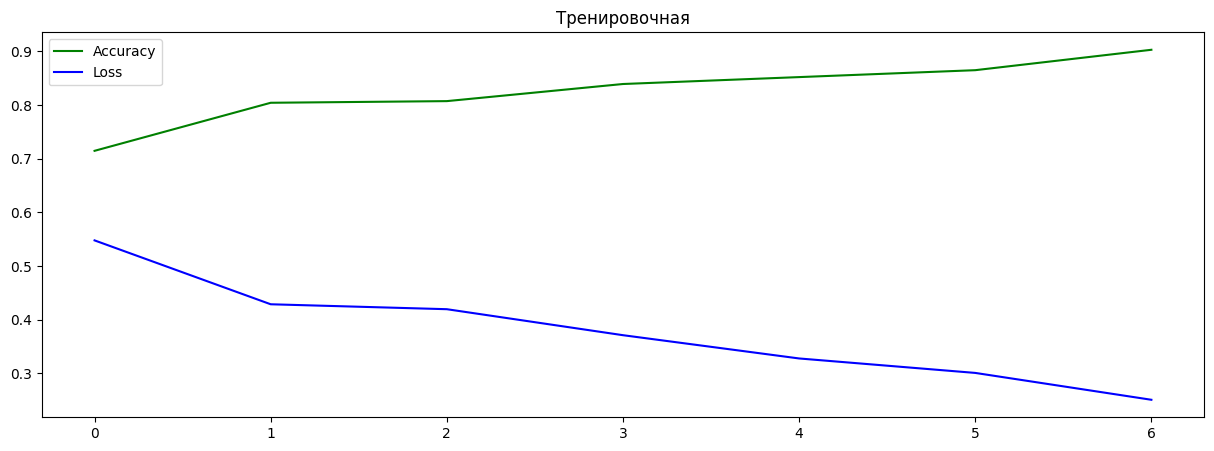

In [56]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

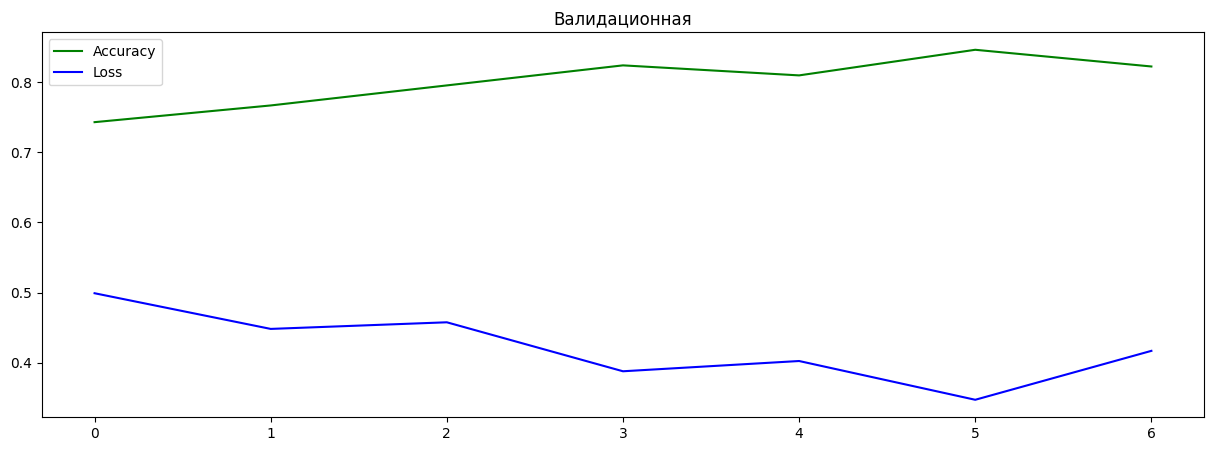

In [55]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_val_values)), accuracy_val_values, color="green")
plt.plot(range(len(loss_val_values)), [
        float(value.detach()) for value in loss_val_values], color="blue")
plt.legend(["Accuracy", "Loss"])

# Пункт 9

сохраняем модель

In [63]:
torch.save(model.state_dict(), os.path.join(r"C:\Users\dstep\OneDrive", "weight.pt"))

# Пункт 10

загрузка модели

In [78]:
model = CNN()
model.load_state_dict(torch.load(os.path.join(r"C:\Users\dstep\OneDrive", "weight.pt")))


<All keys matched successfully>

проверка модели

In [79]:
model.eval()

print(device)

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data
    label = label

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(3)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
    
print(test_loss, test_accuracy)

cuda:0
0.09942965954542161 0.7619047619047619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


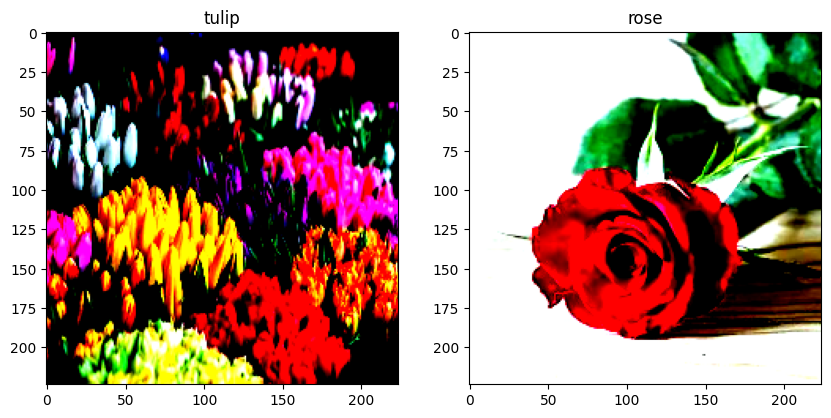

In [94]:
plt.figure(figsize=(10, 5))

for i in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, i + 1)
  plt.title("rose" if (1 if  model(test_dataset[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "tulip")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy())